## Analysis

This file contains all analysis done to produce the final presentation.

### Sections

* Explore Master Data File.
* Analyze Effects of Genre on Revenue.
* Analyze Effects of Runtime on Revenue.
* Find Top Principals by Revenue.


### Explore Master Data File

In [42]:
#Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import numpy as np
%matplotlib inline

#Import Master Data Table
master_df = pd.read_csv('data/Master_Table.csv')
master_df = master_df.drop(columns='Unnamed: 0')
master_df.head()

,Title_ID,Title,Year,Runtime_Minutes,Genres,Lifetime_Gross
0,tt0369610,Jurassic World,2015,124.0,"Action,Adventure,Sci-Fi",652270625.0
1,tt0401729,John Carter,2012,132.0,"Action,Adventure,Sci-Fi",73078100.0
2,tt1179034,From Paris with Love,2010,92.0,"Action,Crime,Thriller",24077427.0
3,tt1194173,The Bourne Legacy,2012,135.0,"Action,Adventure,Thriller",113203870.0
4,tt1219289,Limitless,2011,105.0,"Mystery,Sci-Fi,Thriller",79249455.0


In [4]:
#Check Rows & NaN values
master_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3209 entries, 0 to 3208
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Title_ID         3209 non-null   object 
 1   Title            3209 non-null   object 
 2   Year             3209 non-null   int64  
 3   Runtime_Minutes  3179 non-null   float64
 4   Genres           3205 non-null   object 
 5   Lifetime_Gross   3209 non-null   float64
dtypes: float64(2), int64(1), object(3)
memory usage: 150.5+ KB


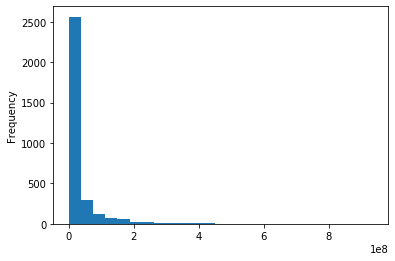

In [5]:
#Distribution of Revenue ($100's of Millions)
master_df['Lifetime_Gross'].plot.hist(bins=25)

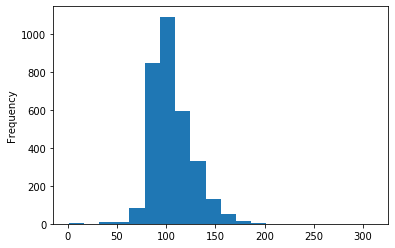

In [6]:
#Distribution of Runtime
master_df['Runtime_Minutes'].plot.hist(bins=20)

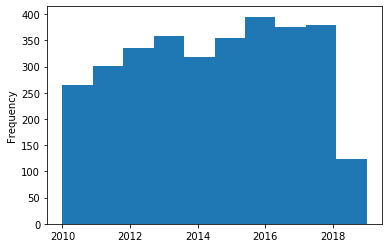

In [7]:
#Distribution of Year
#Roughly even.  Fewer results for 2019 b/c last updated Sept 2019
master_df['Year'].plot.hist()

### Analyze Effects of Genre on Revenue.

The goal is to recommend a revenue-generating genre for the movie studio to produce.

First we create split up our genre data into distinct categories.  Then create a new genre column and merge it back to our main data frame.  Then we look at the yearly trend of the median revenue for each genre.  This will give us an idea of which genres are most successful today.

In [12]:
#Splitting genres into separate columns
main_df = pd.read_csv('data/Master_Table.csv', index_col="Title_ID", usecols = ["Title_ID", "Lifetime_Gross", "Genres", "Year"])
split_genre_df = main_df["Genres"].str.split(",", n=2, expand = True).add_prefix("Genre_")
split_genre_df.head()

,Genre_0,Genre_1,Genre_2
Title_ID,,,
tt0369610,Action,Adventure,Sci-Fi
tt0401729,Action,Adventure,Sci-Fi
tt1179034,Action,Crime,Thriller
tt1194173,Action,Adventure,Thriller
tt1219289,Mystery,Sci-Fi,Thriller


In [13]:
#Merging genres back into the main table
merged_genre_df = main_df.join(split_genre_df)
merged_genre_df = merged_genre_df.reset_index()

In [14]:
#Creating dataframes for each set of genre columns
gen0_df = merged_genre_df[["Year", "Lifetime_Gross", "Genre_0"]].rename(columns = {"Genre_0":"Genre"})
gen1_df = merged_genre_df[["Year", "Lifetime_Gross", "Genre_1"]].rename(columns = {"Genre_1":"Genre"}).dropna()
gen2_df = merged_genre_df[["Year", "Lifetime_Gross", "Genre_2"]].rename(columns = {"Genre_2":"Genre"}).dropna()

In [15]:
#Joining the dataframes back together
genre = gen0_df.append([gen1_df, gen2_df], ignore_index = True)
gen_df = genre.reindex(columns=["Genre", "Year", "Lifetime_Gross"])
gen_df.head()

,Genre,Year,Lifetime_Gross
0,Action,2015,652270625.0
1,Action,2012,73078100.0
2,Action,2010,24077427.0
3,Action,2012,113203870.0
4,Mystery,2011,79249455.0


In [16]:
#Calculating the median for each genre by year
median_gen_df = gen_df.groupby(["Genre", "Year"]).median()

[Text(0, 0.5, 'Gross Revenue (100s of Millions)'), Text(0.5, 0, 'Year')]

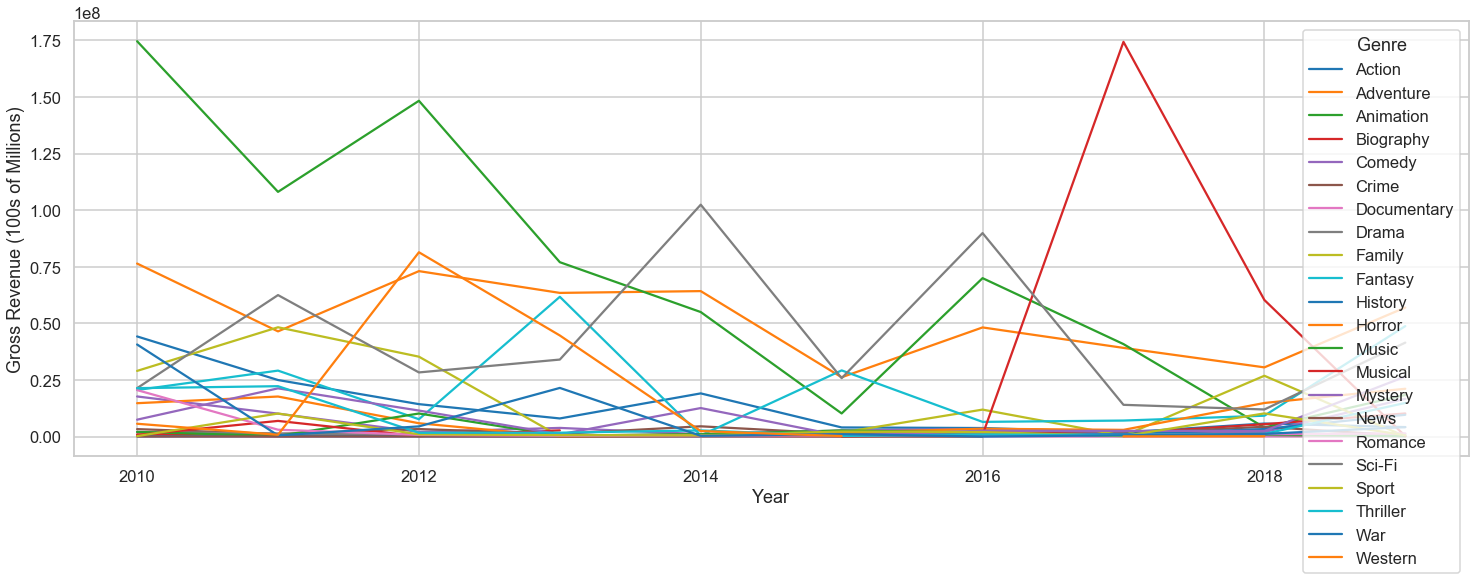

In [17]:
#Set seaborn chart styles
sns.set_style('whitegrid')
sns.set_context("talk") 

#Graph median revenue for all genres
all_median_gen_df = median_gen_df.unstack(level=0)
all_median_gen_df.columns = all_median_gen_df.columns.droplevel()
all_median_gen_df.plot(figsize=(25,8)).set(xlabel = "Year", ylabel = "Gross Revenue (100s of Millions)")

This graph is too crowded and hard to read, so we'll choose 5 top genres and clean up the formatting.

(array([2008., 2010., 2012., 2014., 2016., 2018., 2020.]),
 <a list of 7 Text xticklabel objects>)

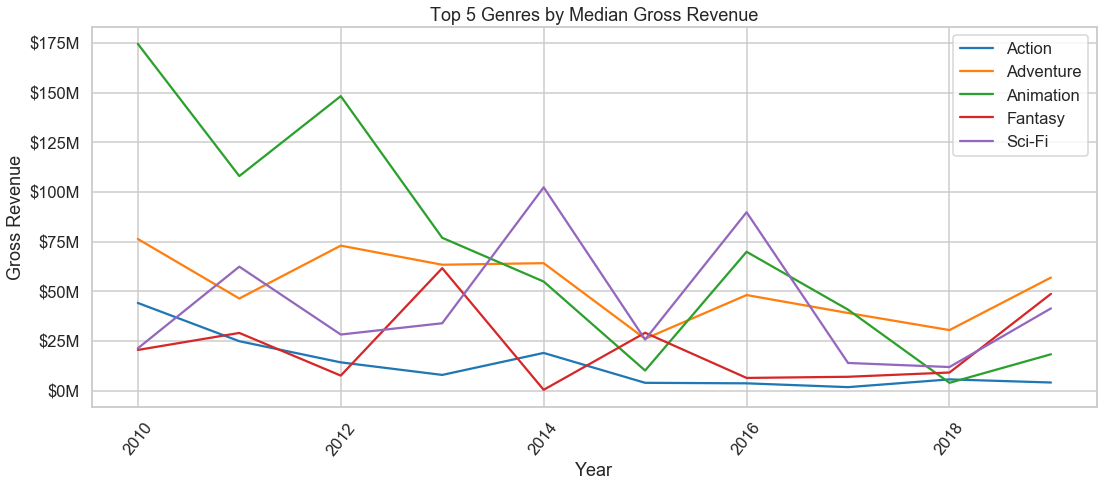

In [18]:
#Filtered Dataframe with top 5 genres
median_5_gen_df = all_median_gen_df[["Action", "Adventure", "Animation", "Fantasy", "Sci-Fi"]]

#Set style, font size, figure size
fig, ax = plt.subplots(figsize=(18, 7))
    
#Format y axis for millions of dollars
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '$' + '{:,.0f}'.format(x/1000000) + 'M'))
    
#Create graph and format labels
g = sns.lineplot(data = median_5_gen_df,
                dashes = False,).set(xlabel = 'Year',
                ylabel = 'Gross Revenue', 
                title = 'Top 5 Genres by Median Gross Revenue')
plt.xticks(rotation=52)


In this chart we can see that Animation earned a lot of revenue in the past, but is trending in the wrong direction.  Sci-Fi and Adventure seem to be fairly stable generators of revenue.  Let's take a closer look at those 2 genres in particular:

(array([2008., 2010., 2012., 2014., 2016., 2018., 2020.]),
 <a list of 7 Text xticklabel objects>)

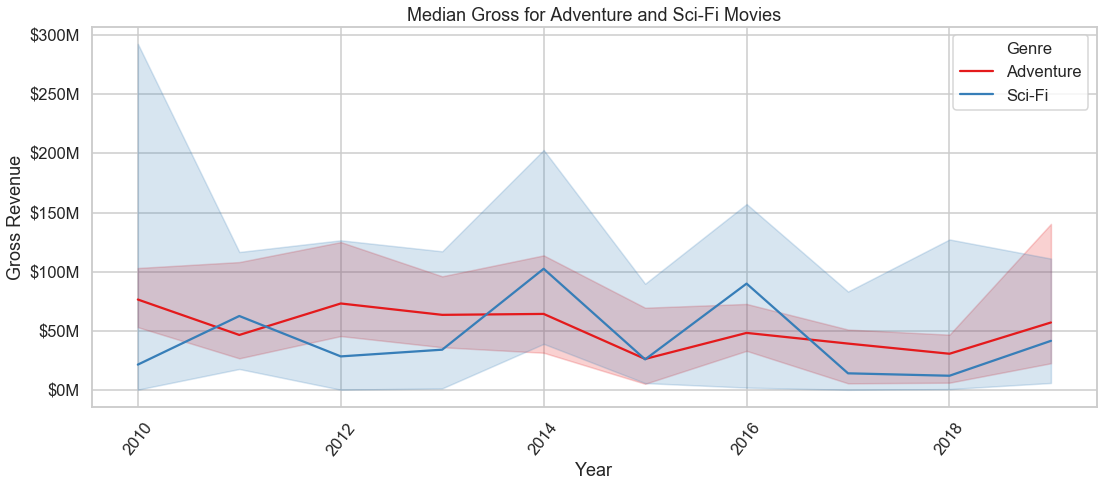

In [19]:
#Creating dataframe with top 2 genres
limited_gens = gen_df[gen_df.Genre.isin(["Sci-Fi", "Adventure"])]

#Graph trend of Sci-Fi and Adventure (including confidence intervals)
fig, ax = plt.subplots(figsize=(18, 7))

ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '$' + '{:,.0f}'.format(x/1000000) + 'M'))

g = sns.lineplot(data = limited_gens, hue="Genre", x="Year", y = "Lifetime_Gross", palette = "Set1", estimator=np.median).set(xlabel = 'Year',
                ylabel = 'Gross Revenue',
                title = 'Median Gross for Adventure and Sci-Fi Movies')

plt.xticks(rotation=52)


This graph shows that Sci-Fi movies have a wider range of revenues, while Adventure movies tend to be more stable generators of revenue.  The highest earning Sci-Fi movies have larger revenues, but more have low earnings as well.


### Analyze Effects of Runtime on Revenue.

Now we'd like to find the optimal length of a movie in order to maximize revenue.

First we explore the data.  Then we graph its relationship via scatterplot.  Finally we choose a binning technique to determine the best runtime.

In [20]:
# Read in Data
master_df = pd.read_csv('data/Master_Table.csv')
master_df = master_df.drop(columns='Unnamed: 0')

In [21]:
#30 movies with null runtime values
#Replace with median runtime
runtime_df = master_df
runtime_df['Runtime_Minutes'].fillna(runtime_df['Runtime_Minutes'].median(), inplace=True)
runtime_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3209 entries, 0 to 3208
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Title_ID         3209 non-null   object 
 1   Title            3209 non-null   object 
 2   Year             3209 non-null   int64  
 3   Runtime_Minutes  3209 non-null   float64
 4   Genres           3205 non-null   object 
 5   Lifetime_Gross   3209 non-null   float64
dtypes: float64(2), int64(1), object(3)
memory usage: 150.5+ KB


In [22]:
#Half of movies are between 1:32 and 1:57 in length
runtime_df[['Runtime_Minutes']].describe()

,Runtime_Minutes
count,3209.000000
mean,105.842318
std,20.713145
min,1.000000
25%,92.000000
50%,102.000000
75%,117.000000
max,310.000000


Now that we know our data, we'll try to find the relationship between revenue and movie length.

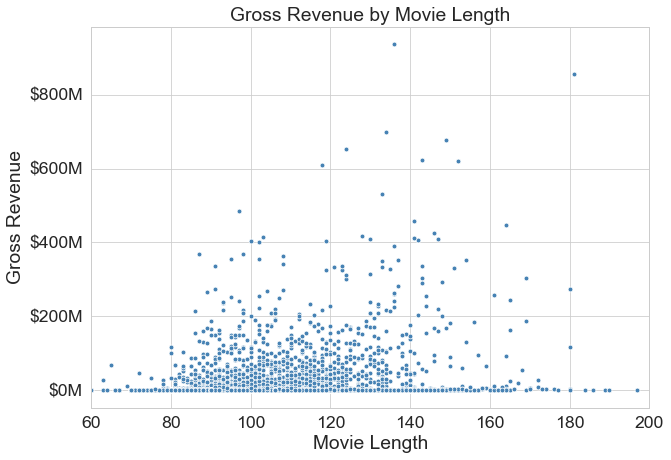

In [27]:
#Graph relationship via scatterplot

#Set style, font size, figure size
sns.set_style('whitegrid')
sns.set_context("paper", font_scale=2) 
fig, ax = plt.subplots(figsize=(10, 7))

# Set the limits of x and y for axes
ax.set_xlim(60, 200)

#Format y axis for millions of dollars
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '$' + '{:,.0f}'.format(x/1000000) + 'M'))



#Create graph and format labels
g = sns.scatterplot(x= runtime_df['Runtime_Minutes'], y=runtime_df['Lifetime_Gross'], data = equal_bins, color='steelblue').set(xlabel = 'Movie Length', ylabel = 'Gross Revenue', title = 'Gross Revenue by Movie Length')

This graph shows us that movies under 80 minutes generate less revenue, but it's difficult to form a conclusion from the rest of the data.  To find the optimal movie time, we'll sort each movie into a bin based on its runtime.  Then we'll find the median revenue for each bin.

In [28]:
#Create bins to sort different movie lengths into.
runtime_df['Runtime_Bins'] = pd.qcut(runtime_df['Runtime_Minutes'], q = 6)
runtime_df['Runtime_Bins'].value_counts()

(0.999, 89.0]       581
(124.333, 310.0]    535
(89.0, 95.0]        535
(110.0, 124.333]    533
(95.0, 102.0]       514
(102.0, 110.0]      511
Name: Runtime_Bins, dtype: int64

In [29]:
#Name the bins for readable charts.
bin_names = ['Very Short', 'Short', 'Medium', 'Medium-Long', 'Long', 'Very Long']
runtime_df['Runtime_Bins'] = pd.qcut(runtime_df['Runtime_Minutes'], q = 6, labels = bin_names)
runtime_df['Runtime_Bins'].value_counts()

Very Short     581
Very Long      535
Short          535
Long           533
Medium         514
Medium-Long    511
Name: Runtime_Bins, dtype: int64

In [30]:
# Get the median revenue generated for each bin
equal_bins = runtime_df.groupby('Runtime_Bins').median()
equal_bins = equal_bins[['Lifetime_Gross']]
equal_bins

,Lifetime_Gross
Runtime_Bins,
Very Short,68243.0
Short,129124.0
Medium,965542.0
Medium-Long,1810078.0
Long,6788692.0
Very Long,2199787.0


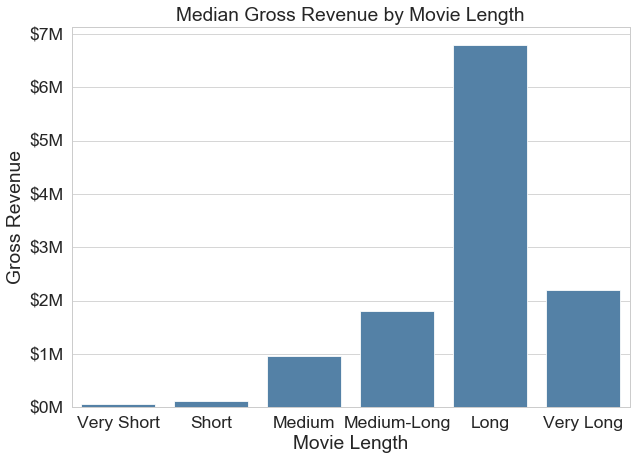

In [31]:
#Create bar graph showing median revenue for each bin.

#Set style, font size, figure size
sns.set_style('whitegrid')
sns.set_context("paper", font_scale=2) 
fig, ax = plt.subplots(figsize=(10, 7))

#Format y axis for millions of dollars
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '$' + '{:,.0f}'.format(x/1000000) + 'M'))



#Create graph and format labels
g = sns.barplot(x= equal_bins.index, y=equal_bins['Lifetime_Gross'], data = equal_bins, color='steelblue').set(xlabel = 'Movie Length', ylabel = 'Gross Revenue', title = 'Median Gross Revenue by Movie Length')

Here we can clearly see the 'Long' movies (110 to 124 min) generate the most revenue on average.  We recommend that the movie studio produces a movie in this length range.

### Find Top Principals by Revenue

Now we want to provide the studio with a shortlist of the top key players in each of 4 main categories: Actors, Directors, Writers, and Cinematographers.

To do this we will filter our People_Master.csv data to show only pricipals with >= 3 movie credits.  This ensures that each recommendation has a solid track record of successful films.

In [32]:
#Read in the data
people_master = pd.read_csv('data/People_Master.csv')
people_master = people_master.drop(columns='Unnamed: 0')
people_master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30854 entries, 0 to 30853
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Title_ID         30854 non-null  object 
 1   Title            30854 non-null  object 
 2   Year             30854 non-null  int64  
 3   Runtime_Minutes  30627 non-null  float64
 4   Genres           30819 non-null  object 
 5   Lifetime_Gross   30854 non-null  float64
 6   Name_ID          30854 non-null  object 
 7   Role             30854 non-null  object 
 8   Name             30854 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 2.1+ MB


Because we'll repeat the graphing process 4 times (once for each category), we'll define some functions to get the job done.

In [35]:
#Define Function to Get median revenue for Top Actors/Directors/etc
def median_revenue(role):
    filter_df = people_master.loc[(people_master['Role'] == role)]
    filter_df = filter_df.groupby('Name').filter(lambda x: len(x) >= 3).reset_index()
    top_df = filter_df.groupby('Name').median().sort_values(by='Lifetime_Gross', ascending=False)
    return top_df[['Lifetime_Gross']].head(10)

In [36]:
#Output formatted Graphs
def graph_top_roles(top_roles_data, role, color_palette):
    """Purpose: 
    Create formatted seaborn graph based on top 10 median revenue dataframes.
    
    Input: 
    top_roles_data == dataframe ('median_act' for example)
    role == String choosing which role you want to analyze ('actor', 'director', etc.)
    color_palette = seaborn palette name as a string.
    
    """
    #Set style, font size, figure size
    sns.set_style('whitegrid')
    sns.set_context("paper", font_scale=2) 
    fig, ax = plt.subplots(figsize=(10, 7))
    
    #Format y axis for millions of dollars
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '$' + '{:,.0f}'.format(x/1000000) + 'M'))
    
    #Create graph and format labels
    g = sns.barplot(x= top_roles_data.index, y=top_roles_data['Lifetime_Gross'], data = top_roles_data, palette=color_palette).set(xlabel = (role.title()+'s'), ylabel = 'Gross Revenue', title = 'Top 10 '+ role.title() + 's' + ' by Gross Revenue')
    plt.xticks(rotation=52)

Now we'll use our functions to generate a new dataframe for each category.

In [37]:
#Get Median Rev DFs for each role
median_act = median_revenue('actor')
median_dir = median_revenue('director')
median_cin = median_revenue('cinematographer')
median_wri = median_revenue('writer')

Now we graph each group of principals.

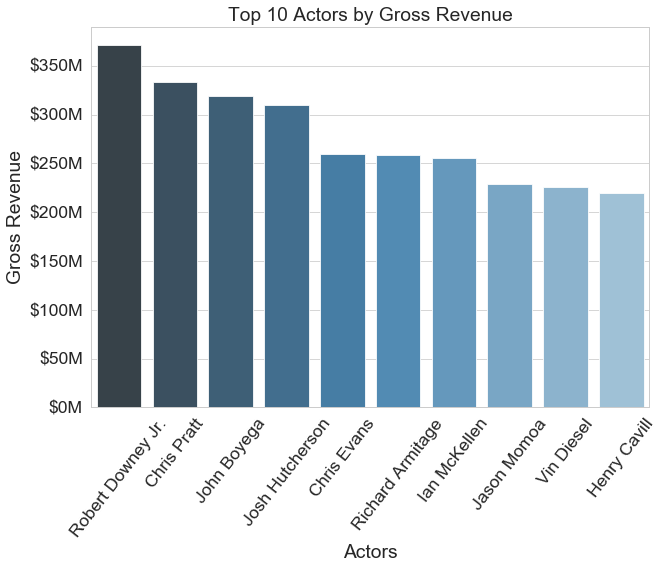

In [38]:
#Top actors graph
graph_top_roles(median_act, 'actor', 'Blues_d')

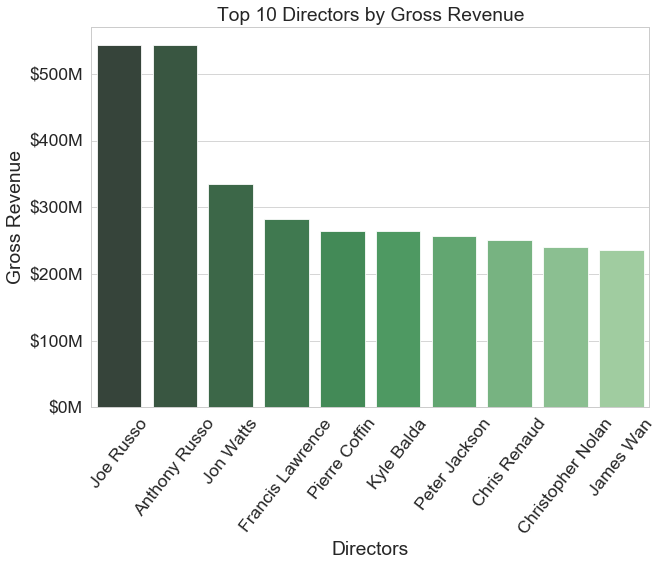

In [39]:
#Top directors graph
graph_top_roles(median_dir, 'director', 'Greens_d')

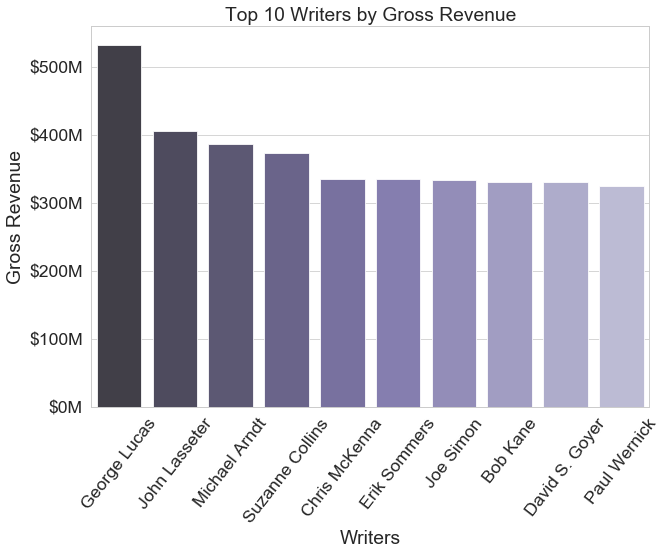

In [40]:
#Top writers graph
graph_top_roles(median_wri, 'writer', 'Purples_d')

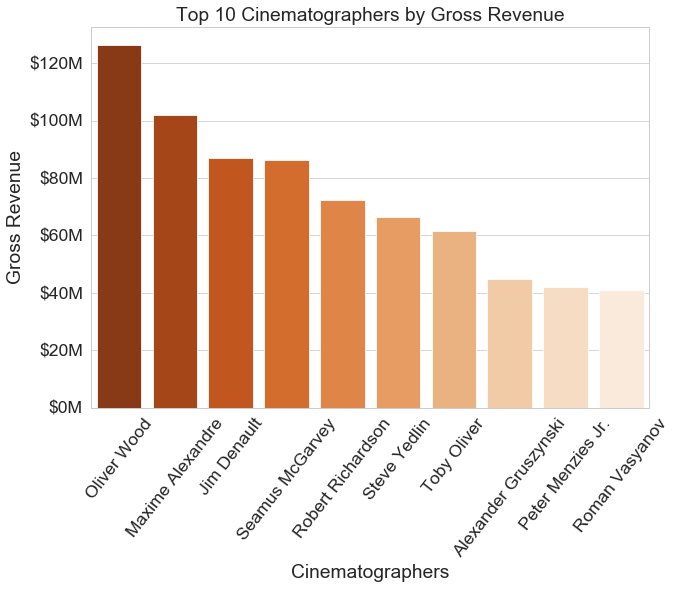

In [41]:
#Top cinematographers graph
graph_top_roles(median_cin, 'cinematographer', 'Oranges_r')

Now we have our shortlists of recommended principals for each of the 4 key roles!

Take note that many Actors and Directors are in the top 10 in their field because they've participated in successful movie franchises like The Avengers, Fast & Furious, and The Hunger Games.  Some writers generate revenue from franchises while others are tied to successful studios & genres of film.  The dropoff in median revenue for cinematographers is steeper, and they're less tied to franchises.